REQUIREMENTS: Classify the input audio data in two expected categories: air conditioner sounds and drill sounds. 

Make use of: 
- WT (Wavelet Transform) to obtain a high resolution in both frequency and time domains
- PCA (Principal component analysis) in order to project the data to a lower dimensional space, reducing the complexity of the problem
- SVM (Support Vector Machine) to classify the input data

In [1]:
!conda config --add channels conda-forge
!conda install -y libsndfile 
!conda install pywt
!conda install soundfile 
!conda install librosa 

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.8-main

  added / updated specs:
    - libsndfile


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.5.30          |   py38h578d9bd_0         141 KB  conda-forge
    gettext-0.19.8.1           |    h0b5b191_1005         3.6 MB  conda-forge
    libflac-1.3.3              |       he1b5a44_0         517 KB  conda-forge
    libogg-1.3.4               |       h7f98852_1         206 KB  conda-forge
    libsndfile-1.0.29          |       he1b5a44_0         534 KB  conda-forge
    libvorbis-1.3.7            |       he1b5a44_0         287 KB  conda-forge
    python_abi-3.8             |           2_cp

In [2]:
import os
import sys
import types
import ibm_boto3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from zipfile import ZipFile
from botocore.client import Config

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

import soundfile as sf
import librosa

import pywt
    
%matplotlib inline

In [3]:
# Download the input data for our algorithm: Urban Sounds Dataset  
!rm audio_data
!rm audio_data.zip
!wget https://github.com/GabriellaN/ml/raw/master/audio_data.zip
!ls 

rm: cannot remove 'audio_data': No such file or directory
rm: cannot remove 'audio_data.zip': No such file or directory
--2021-10-20 12:02:01--  https://github.com/GabriellaN/ml/raw/master/audio_data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GabriellaN/ml/master/audio_data.zip [following]
--2021-10-20 12:02:02--  https://raw.githubusercontent.com/GabriellaN/ml/master/audio_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25195931 (24M) [application/zip]
Saving to: ‘audio_data.zip’

audio_data.zip      100%[===================>]  24.03M   147MB/s    in 0.2s    

2021-10-20 12:02

The data used for this demonstration comes from the Urban Sounds Dataset. 
This dataset and its taxonomy is presented in: 
A Dataset and Taxonomy for Urban Sound Research by J. Salamon, C. Jacoby and J.P. Bello, 22nd International Conference on Multimedia, Orlando USA, Nov. 2014.

For simplicity, the dataset is sampled and a subset of less then 20 audio clips from two categories are used: air conditioner (AC) and drill.

In [4]:
f = open("audio_data.zip", "rb")
data_bytes = BytesIO(f.read())
zip_file = ZipFile(data_bytes)

In [5]:
ZipFile.namelist(zip_file)

['audio_data/',
 'audio_data/ac/',
 'audio_data/ac/101729-0-0-1.wav',
 'audio_data/ac/101729-0-0-11.wav',
 'audio_data/ac/101729-0-0-12.wav',
 'audio_data/ac/101729-0-0-13.wav',
 'audio_data/ac/101729-0-0-14.wav',
 'audio_data/ac/101729-0-0-16.wav',
 'audio_data/ac/101729-0-0-17.wav',
 'audio_data/ac/101729-0-0-18.wav',
 'audio_data/ac/101729-0-0-19.wav',
 'audio_data/ac/101729-0-0-21.wav',
 'audio_data/ac/101729-0-0-22.wav',
 'audio_data/ac/101729-0-0-23.wav',
 'audio_data/ac/101729-0-0-24.wav',
 'audio_data/ac/101729-0-0-26.wav',
 'audio_data/ac/101729-0-0-28.wav',
 'audio_data/ac/101729-0-0-29.wav',
 'audio_data/ac/101729-0-0-3.wav',
 'audio_data/drill/',
 'audio_data/drill/103199-4-0-0.wav',
 'audio_data/drill/103199-4-0-3.wav',
 'audio_data/drill/103199-4-0-4.wav',
 'audio_data/drill/103199-4-0-5.wav',
 'audio_data/drill/103199-4-0-6.wav',
 'audio_data/drill/103199-4-1-0.wav',
 'audio_data/drill/103199-4-2-0.wav',
 'audio_data/drill/103199-4-2-1.wav',
 'audio_data/drill/103199-4-2

In [6]:
audio_data = []
labels = []
sampling_rate = []
file_names = []

for file_name in ZipFile.namelist(zip_file):
    # Skip directories
    if not os.path.basename(file_name):
        continue
    
    audio_file = None
    if file_name.startswith("audio_data/ac/"):
        # Associate label 0 with files that contain air conditioner sounds. This will be usefull for evaluating the accuracy of our solution.
        labels.append(0)
        audio_file = zip_file.open(file_name)
    elif file_name.startswith("audio_data/drill/"):
        # Associate label 1 with files that contain drill sounds. This will be usefull for evaluating the accuracy of our solution.
        labels.append(1)
        audio_file = zip_file.open(file_name)
    else:
        print("Unknown file class. Skipping.")

    if audio_file is not None:
        file_names.append(file_name)
        tmp = BytesIO(audio_file.read())
        # Sampling rate or sampling frequency defines the number of samples per second (or per other unit) taken from a continuous signal to make a discrete or digital signal. 
        data, samplerate = sf.read(tmp)
        audio_data.append(data)
        sampling_rate.append(samplerate)   

In [7]:
for index in range(len(audio_data)):
    # Adjust high sampling rates. 
    if (sampling_rate[index] == 48000):
        audio_data[index] = librosa.resample(audio_data[index], 48000, 44100)
        sampling_rate[index] = 44100


In [8]:
def to_mono(data):
    # ndim return the number of dimensions of an array
    if data.ndim > 1:
        # Computes the arithmetic mean along the specified axis. Returns the average of the array elements.
        data = np.mean(data, axis=1)
    return data

for index in range(len(audio_data)):
    audio_data[index] = to_mono(audio_data[index])

In [9]:
print("Label for audio_data[1] (amplitudes of air conditioner sounds): ", labels[1])
print ('The shape of audio_data[1] (amplitudes of air conditioner sounds):', audio_data[1].shape, '= (number_of_rows, number_of_columns)')
print ('Samples from audio_data[1] (amplitudes of air conditioner sounds):')
print (audio_data[1])

Label for audio_data[1] (amplitudes of air conditioner sounds):  0
The shape of audio_data[1] (amplitudes of air conditioner sounds): (192000,) = (number_of_rows, number_of_columns)
Samples from audio_data[1] (amplitudes of air conditioner sounds):
[-0.00849432 -0.00923008 -0.01809108 ... -0.00562297 -0.00769845
 -0.00795862]


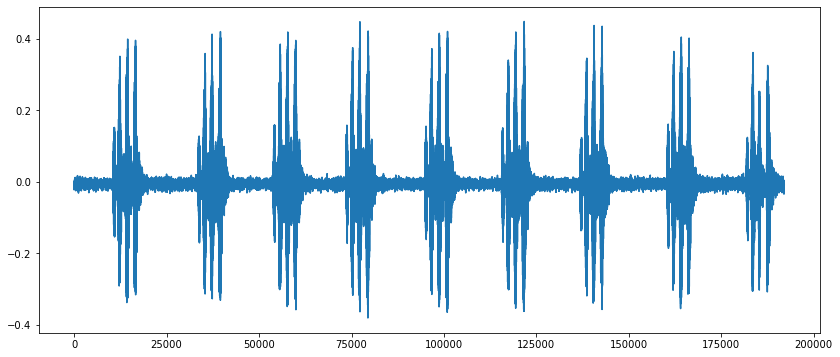

In [10]:
# 2D Plot of audio_data[1] (amplitudes of air conditioner sounds):
fig = plt.figure(figsize=(14,6))
plt.plot(audio_data[1])

In [11]:
print("Label for audio_data[21] (amplitudes of drill sounds): ", labels[21])
print ('The shape of audio_data[21] (amplitudes of drill sounds):', audio_data[21].shape, '= (number_of_rows, number_of_columns)')
print ('Samples from audio_data[21] (amplitudes of drill sounds):')
print (audio_data[21])

Label for audio_data[21] (amplitudes of drill sounds):  1
The shape of audio_data[21] (amplitudes of drill sounds): (176400,) = (number_of_rows, number_of_columns)
Samples from audio_data[21] (amplitudes of drill sounds):
[ 0.20809937  0.1473999   0.08853149 ... -0.20149231 -0.17678833
 -0.12565613]


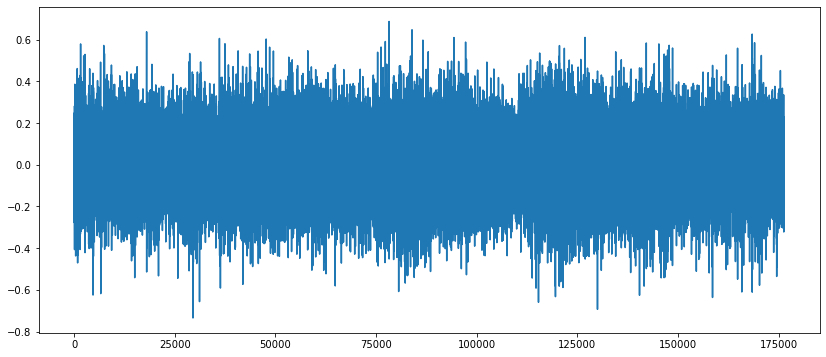

In [12]:
# 2D Plot Plot audio_data[21] (amplitudes of drill sounds):
fig = plt.figure(figsize=(14,6))
plt.plot(audio_data[21])

In [13]:
# arange returns evenly spaced values within a given interval. Values are generated within the half-open interval [start, stop).
scales = np.arange(1, 101)   

# In Lab 31 WS: FFT (Fast Fourier Tr) and Neural Networks, we used the Fourier Transformation. This algorithm transforms the data from the time domain to the frequency domain. 
# Fourier Transformation is an extremely powerful mathematical tool that allows us to view our signals in a different domain, inside which several difficult problems become very simple to analyze.
# But a better approach for analyzing signals (especially signals with a dynamical frequency spectrum) is the Wavelet Transform. 
# The Wavelet Transform has a high resolution in both frequency and time domains: it does not only tell us which frequencies are present in a signal, but also at which time these frequencies have occurred.
# Therefore, we are going to apply the Wavelet transform to our input data.
# REF: https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

# Python implementation for Wavelet Transform:
# pywt stands for PyWavelets: an open source wavelet transform software for Python. 
# cwt stands for Continuous Wavelet Transform.  
# PARAMETERS:    
# - scales: the wavelet scales to use.
# The smaller the scale factor, the more “compressed” the wavelet. Conversely, the larger the scale, the more stretched the wavelet, making it sensitive to lower frequencies in the signal. 
# The following figure illustrates this for wavelets at scales 1,2, and 4: https://www.mathworks.com/help/wavelet/gs/ch01_intro54.png
# - 'morl' sets the continuous wavelets algorithm to use. Note: A variety of continuous wavelets have been implemented, but the implementation that we use here is: Morlet Wavelet 'morl'.
# OUTPUT:
# - coeff: array_like. It is the continuous wavelet transform of the input signal for the given scales and implementaion algorithm. The first axis of coefs corresponds to the scales. The remaining axes match the shape of the data.
# - freqs: array_like. If the unit of sampling period is seconds and given, than FREQUENCES are IN HERTZ. 
# REF: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html   
coeff1, freqs1 = pywt.cwt(audio_data[1][:25000], scales, 'morl')
coeff2, freqs2 = pywt.cwt(audio_data[21][:25000], scales, 'morl')

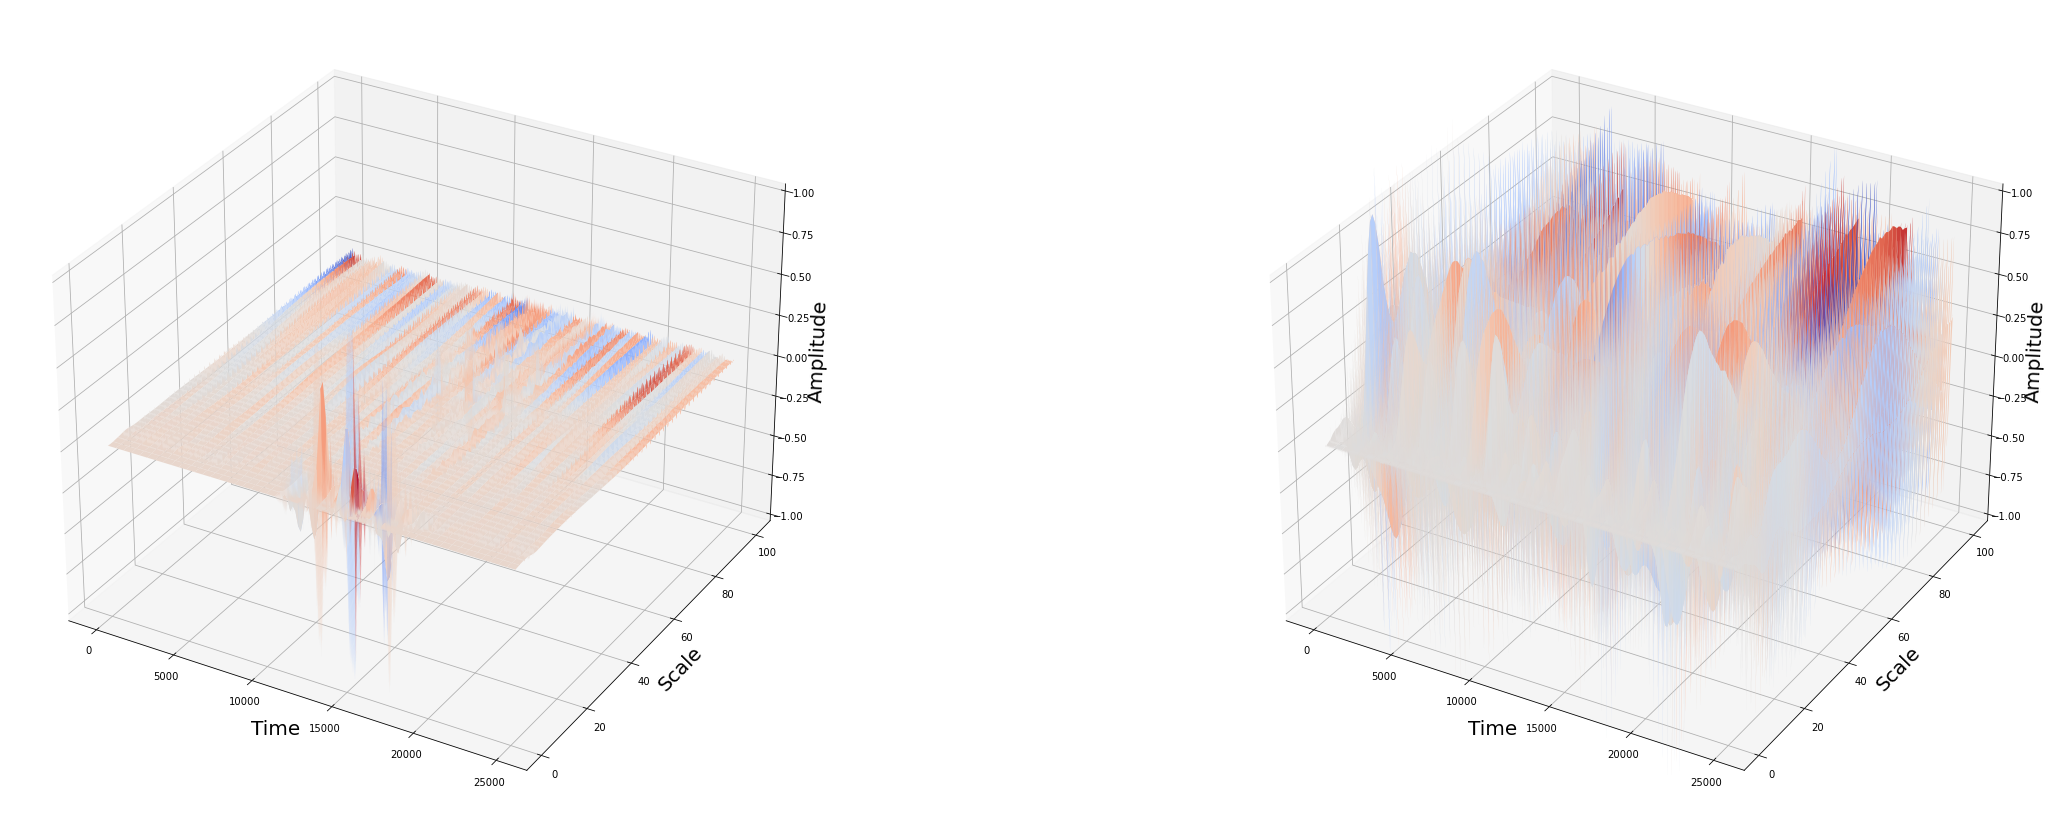

In [14]:
# 3D PLOT OF THE INPUT DATA:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create a new figure:
fig = plt.figure(figsize=(40,15))

# 3D PLOT OF THE AIR CONDITIONER DATA:

# Parameters: (nrows, ncols, index, kwargs)
# The position of the subplot is described by nrows, ncols, index. The subplot will take the index position on a grid with nrows rows and ncols columns. The index starts at 1 in the upper left corner and increases to the right.
# kwargs = the keyword arguments for the returned Axes base class. In this case: projection='3d'.
# REF: https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.add_subplot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

# Generate X for Time axis:
X = np.arange(1, 25001, 1)
# Generate Y for Scale axis:
Y = np.arange(1, 101, 1)

# The numpy.meshgrid function is used to create a rectangular grid out of two given one-dimensional arrays representing the Cartesian indexing or Matrix indexing. 
# meshgrid function returns two 2-Dimensional arrays representing the X and Y coordinates of all the points:
X, Y = np.meshgrid(X, Y)

# coeff1 will give us the Amplitude axis, but it will pe limited to (-1,1). See: ax1.set_zlim3d(-1,1) below.
# cmap stands for colormap.
ax1.plot_surface(X, Y, coeff1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax1.set_xlabel("Time", fontsize=20)
ax1.set_ylabel("Scale", fontsize=20)
ax1.set_zlabel("Amplitude", fontsize=20)
ax1.set_zlim3d(-1,1)

# 3D PLOT OF OUR DRILL DATA:

# Parameters: (nrows, ncols, index, kwargs)
# The position of the subplot is described by nrows, ncols, index. The subplot will take the index position on a grid with nrows rows and ncols columns. The index starts at 1 in the upper left corner and increases to the right.
# kwargs = the keyword arguments for the returned Axes base class. In this case: projection='3d'.
# REF: https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.add_subplot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

# coeff1 will give us the Amplitude axis, but it will pe limited to (-1,1). See: ax1.set_zlim3d(-1,1) below.
# cmap stands for colormap.
ax2.plot_surface(X, Y, coeff2, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax2.set_xlabel("Time", fontsize=20)
ax2.set_ylabel("Scale", fontsize=20)
ax2.set_zlabel("Amplitude", fontsize=20)
ax2.set_zlim3d(-1,1)

plt.show()

In [15]:
# IMPORTANT:
# Apply WT (Wavelet Transform) to audio_data and PCA (Principal Component Analysis) to the resulting coefficients in order to project them to a lower dimensional space.
# Then add the updated coefficients to the list of features used by SVM to classify the input data.

from sklearn.decomposition import PCA

# Initialise PCA:
# n_components = Number of components to keep. If n_components is not set, all components are kept.
# REF: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components=1)

# Create an empty features array.
# Note: numpy.empty returns a new array of the given shape: (0 rows, 100 columns), without initializing entries.
# REF: https://numpy.org/doc/stable/reference/generated/numpy.empty.html
features = np.empty((0,100))

for ind in range(len(audio_data)):
    print('.', end='')    
    
    # REMEMBER THAT:    
    # The Wavelet Transform is an extremely powerful mathematical tool that gives us a high resolution in both frequency and time domains: 
    # it does not only tell us which frequencies are present in a signal, but also at which time these frequencies have occurred.
    #
    # Python implementation of the Wavelet Transform:
    # pywt stands for PyWavelets: an open source wavelet transform software for Python. 
    # cwt stands for Continuous Wavelet Transform.  
    # PARAMETERS:    
    # - scales: the wavelet scales to use.
    # The smaller the scale factor, the more “compressed” the wavelet. Conversely, the larger the scale, the more stretched the wavelet, making it sensitive to lower frequencies in the signal. 
    # The following figure illustrates this for wavelets at scales 1,2, and 4: https://www.mathworks.com/help/wavelet/gs/ch01_intro54.png
    # - 'morl' sets the continuous wavelets algorithm to use. Note: A variety of continuous wavelets have been implemented, but the implementation that we use here is: Morlet Wavelet 'morl'.
    # OUTPUT:
    # - coeff: array_like. It is the continuous wavelet transform of the input signal for the given scales and implementaion algorithm. The first axis of coefs corresponds to the scales. The remaining axes match the shape of the data.
    # - freqs: array_like. If the unit of sampling period is seconds and given, than FREQUENCES are IN HERTZ. 
    # REF: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html 
    coeff, freqs = pywt.cwt(audio_data[ind][:25000], scales, 'morl')
    
    # numpy.vstack(tup): stacks arrays in sequence vertically (row wise).
    # REF: https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
    # pca.fit_transform(coeff) applies PCA (Principal component analysis) to coeff data in order to project it to a lower dimensional space. 
    # Than, we add coeff to the empty features array.
    features = np.vstack([features, pca.fit_transform(coeff).flatten()])

...................................

In [16]:
# Split the data (features, labels) into random train and test subsets.
# Note: features and labels must have the same length.
# test_size: should be between 0.0 and 1.0, representing the proportion of the dataset to include in the test split.
# random_state: controls the shuffling applied to the data before applying the split; pass an int for reproducible output across multiple function calls.
# REF: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=1234)

In [17]:
# Use SVM (Support Vector Machine) to classify the input data into air conditioner sounds and drill sounds categories.
# REMEMBER THAT:
# SVM is a supervised machine learning algorithm which can be used for both classification and regression challenges. But it is mostly used in classification problems. 
# In the SVM algorithm, we plot each data item as a point in an n-dimensional space (where n is the number of features we have) with the value of each feature being the value of a particular coordinate. 
# Then, we perform the classification by finding the hyper-plane that differentiates the two classes very well. 
# Example: https://www.researchgate.net/publication/304611323/figure/fig8/AS:668377215406089@1536364954428/Classification-of-data-by-support-vector-machine-SVM.png
# SVM works on small datasets too, but SVM is more powerful in building machine learning models on complex datasets.
# REF SVM: https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

# REF SVC implementation of SVM: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
clf = svm.SVC()

# Fit the SVM model according to the given training data:
clf.fit(X_train, y_train)

SVC()

In [18]:
# Perform classification on samples in X_test:
y_pred = clf.predict(X_test)

# Compute and display the accuracy score for our predictions:
# The set of labels predicted for a sample must exactly match the corresponding set of labels in y_test
# REF: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("Accuracy : %.2f%%" % (accuracy_score(y_test, y_pred) * 100))

Accuracy : 100.00%
